In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d rizwan123456789/potato-disease-leaf-datasetpld #veri setinin buraya yapıştır
! unzip /content/potato-disease-leaf-datasetpld.zip

In [6]:
import os
os.chdir('/content/PLD_3_Classes_256')
os.listdir()

['Training', 'Validation', 'Testing']

In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

from tensorflow import keras
from tensorflow.keras.applications import ResNet152V2, ResNetRS50, VGG16 ,MobileNet,Xception #feature maps
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense #yapay sinir ağı
from tensorflow.keras.models import Model

In [8]:
#data veri arttırımı
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train = datagen.flow_from_directory('/content/PLD_3_Classes_256/Training', seed=123, target_size=(256,256), subset='training')
val = datagen.flow_from_directory('/content/PLD_3_Classes_256/Training', seed=123, target_size=(256,256),subset='validation')

# Test dataset for evaluation
datagen2 = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test = datagen2.flow_from_directory('/content/PLD_3_Classes_256/Testing')

Found 3251 images belonging to 3 classes.
Found 0 images belonging to 3 classes.
Found 405 images belonging to 3 classes.


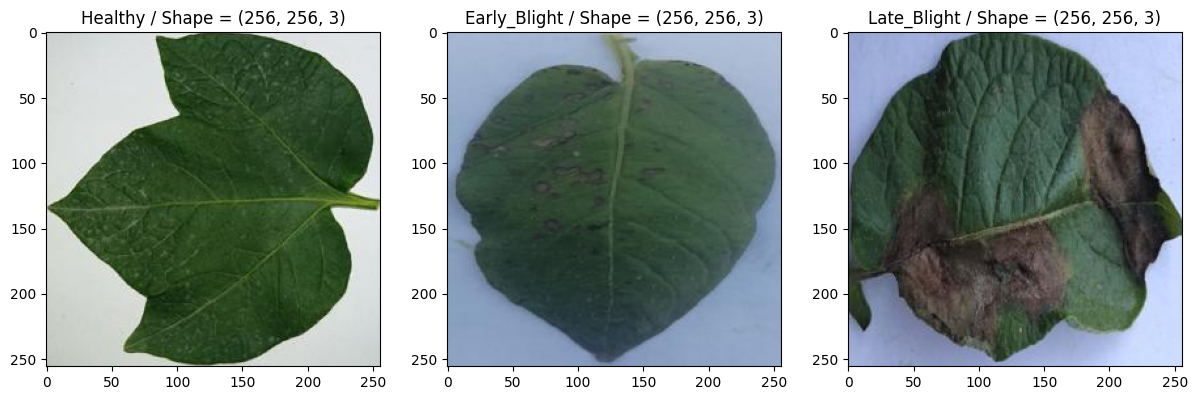

In [9]:
classes = os.listdir('Training')
classes
plt.figure(figsize=(25,10))
for i in enumerate(classes):
    pic = os.listdir('Training/'+i[1])[0]
    image = Image.open('Training/'+i[1]+'/'+pic)
    image = np.asarray(image)
    plt.subplot(2,5,i[0]+1)
    plt.title('{0} / Shape = {1}'.format(i[1], image.shape))
    plt.imshow(image)
plt.show()

In [ ]:
base_model = keras.applications.Xception(
    input_shape=(256,256,3),
    include_top=False,
    weights="imagenet"
)

for layer in base_model.layers[:140]:
    layer.trainable = False

for layer in base_model.layers[140:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1000, activation='relu')(x)
pred = Dense(3, activation='softmax')(x)  # 3 sınıf olduğunu varsayarak çıktı katmanını 3 nöronlu olarak düzenledim

model = Model(inputs=base_model.input, outputs=pred)
model.summary()

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_activations=True,
    show_dtype=True,
    show_layer_names=True,
    show_trainable=True
)

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history=model.fit(train, batch_size=32, epochs=4, validation_data=val)


Epoch 1/4
102/102 [==============================] - 60s 515ms/step - loss: 0.6421 - accuracy: 0.7576
Epoch 2/4
102/102 [==============================] - 52s 510ms/step - loss: 0.4292 - accuracy: 0.8462
Epoch 3/4
102/102 [==============================] - 51s 500ms/step - loss: 0.3617 - accuracy: 0.8674
Epoch 4/4
102/102 [==============================] - 53s 514ms/step - loss: 0.3156 - accuracy: 0.8920


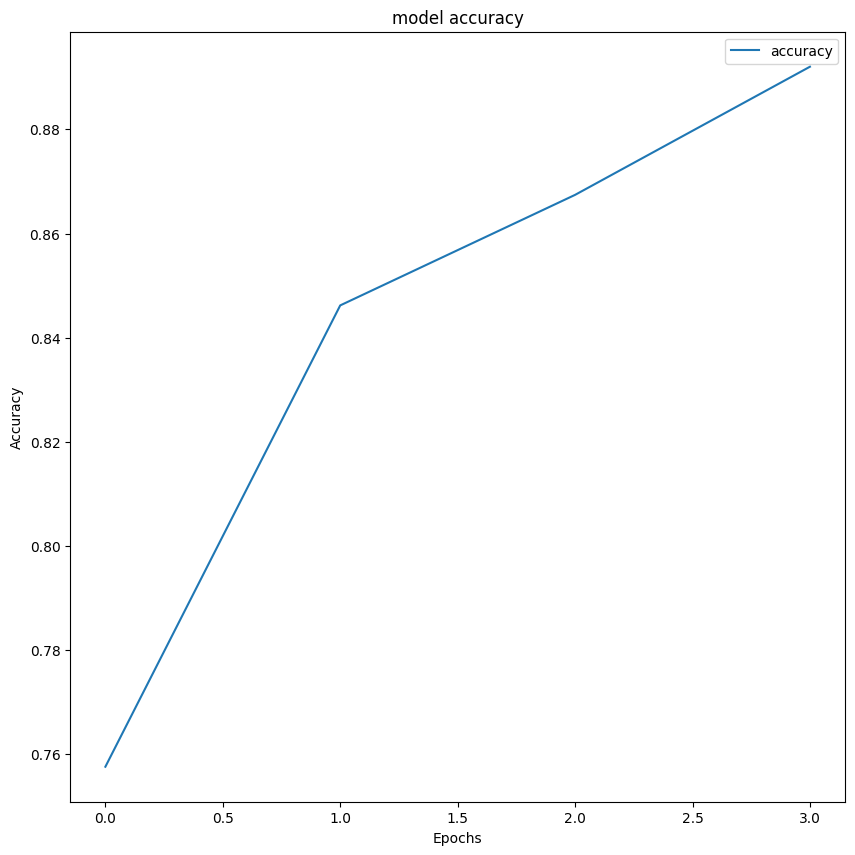

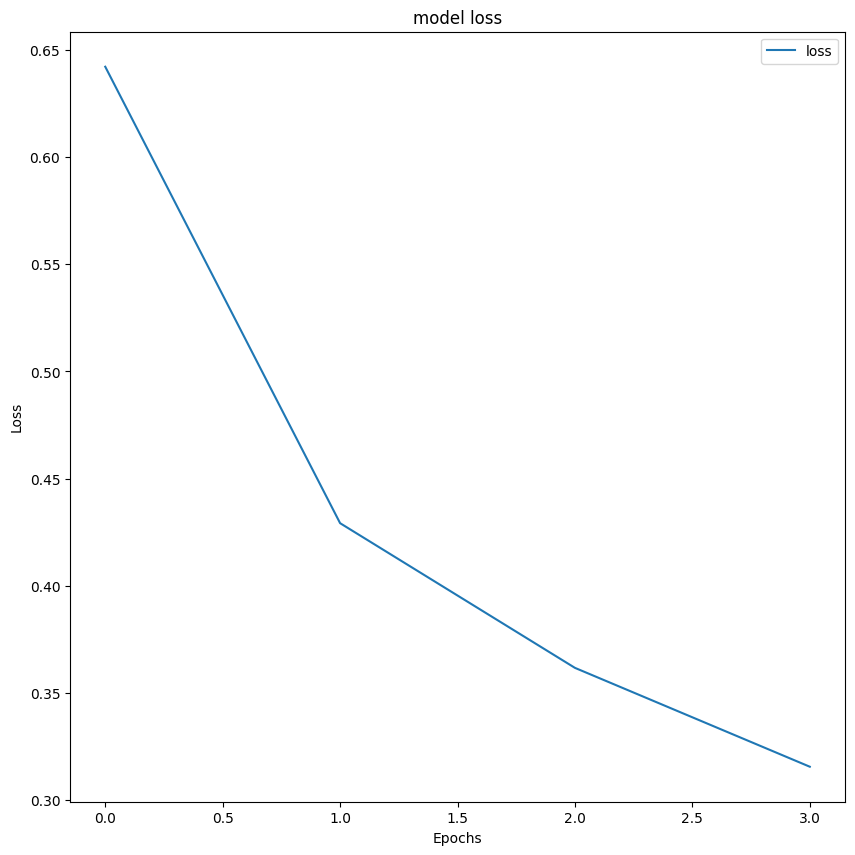

In [24]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["accuracy","Validation Accuracy"])
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["loss","Validation Loss"])
plt.show()

In [ ]:
y_real=[]
all_pred=[]
count=0
for x,y in test:
  predict=model.predict(x)

  for i in predict:
    all_pred.append(np.argmax(i)+1)
  for i in y:
    i=np.argmax(i)+1
    y_real.append(i)

  if len(y_real)==len(test.filepaths):
    break

In [26]:
target_names =[]
for key,value in test.class_indices.items(): #Mevcut test datamızdaki sınıfların numarısı almış oluruz
  target_names.append(f'condition: {key}')

In [27]:
from sklearn import metrics
report=metrics.classification_report(y_real,all_pred,target_names=target_names)
conf_efficnet=metrics.confusion_matrix(y_real,all_pred)

In [28]:
import itertools
def plot_confusion_matrix(cnf_matrix, numbers_type='numbers_and_percentage', class_names=target_names, title='Confusion matrix', cmap=plt.cm.Blues, file_name='confusionmatrix.png'):
    combined = True
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = 0.8*cnf_matrix.max() / 1.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        if numbers_type == 'numbers_and_percentage':
            st1 = '{:.2f}%'.format(100 * cnf_matrix_normalized[i, j])
            st2 = '({:2d})'.format(cnf_matrix[i, j])
            plt.text(j, i, st1+st2,
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

        elif numbers_type == 'percentage':
            fmt = '.2f'
            plt.text(j, i, format(cnf_matrix_normalized[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")
        else:
            fmt = 'd'
            plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(file_name)

    return

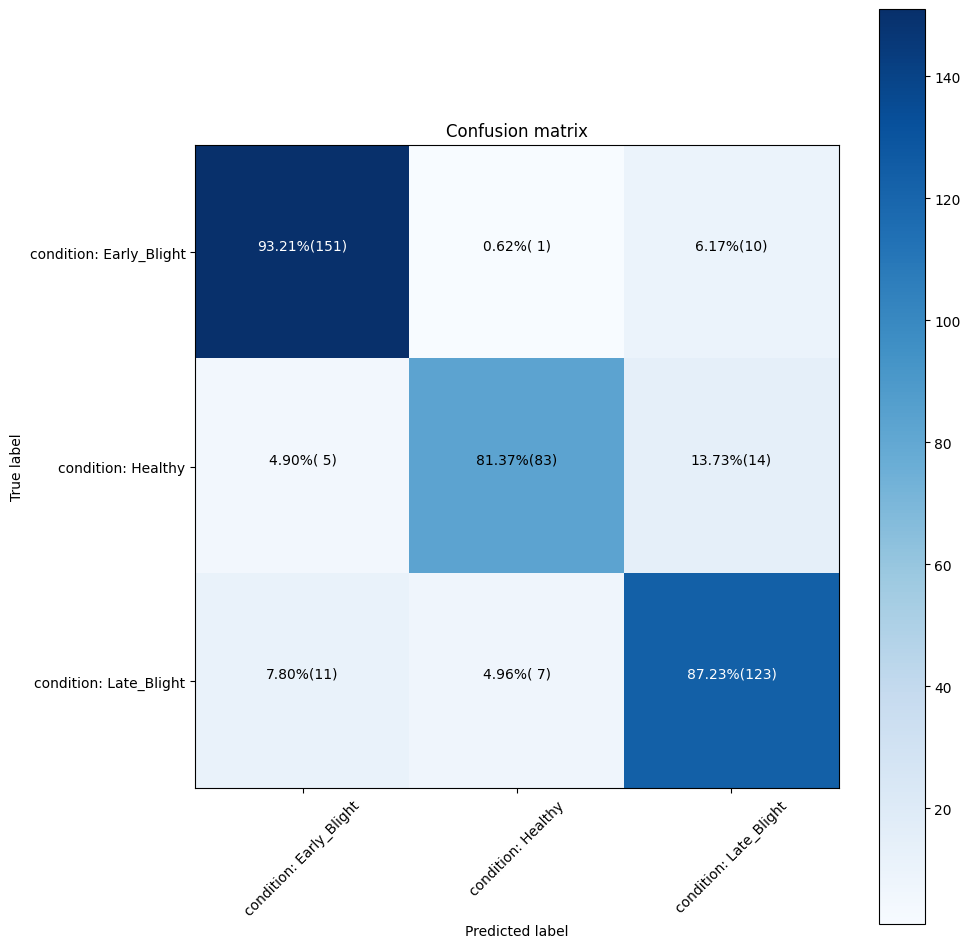

In [29]:
plot_confusion_matrix(conf_efficnet)